# weighted mean in transformed space
this is a trash and hacky code I'm still not sure how to clean up

`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

In [5]:
import xarray as xr
import xesmf as xe
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import combine_datasets
from cmip6_preprocessing.postprocessing import merge_variables
from dask.diagnostics import ProgressBar
from xgcm import Grid
from xhistogram.xarray import histogram
import pandas as pd
import scipy

from xgcm.autogenerate import generate_grid_ds

from cmip6_preprocessing.postprocessing import match_metrics


In [6]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

# load data sets
I changed the saved datasets so that they conserve the `lev_bounds` attribute. I think they are otherwise they same and can be used the same

did select winter mixed layer? No i did not I'll need to change these datasets again

In [7]:
dd = {}
dd['UKESM1-0-LL.gn.historical.Omon'] = xr.open_mfdataset('UKESM1.nc').sel(y = slice(-80,-30))
dd['CanESM5-CanOE.gn.historical.Omon']= xr.open_mfdataset('CanESM5CanOE.nc').sel(y = slice(-80,-30))
dd['CNRM-ESM2-1.gn.historical.Omon']= xr.open_mfdataset('CNRM.nc').sel(y = slice(-80,-30))
dd['CanESM5.gn.historical.Omon']= xr.open_mfdataset('CanESM5.nc').sel(y = slice(-80,-30))
dd['IPSL-CM6A-LR.gn.historical.Omon']= xr.open_mfdataset('IPSL.nc').sel(y = slice(-80,-30))
dd['CESM2-WACCM.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM.nc').sel(y = slice(-80,-30))
dd['CESM2.gr.historical.Omon']= xr.open_mfdataset('CESM2.nc').sel(y = slice(-80,-30))
dd['CESM2-WACCM-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-WACCM-FV2.nc').sel(y = slice(-80,-30))
dd['GFDL-ESM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-ESM4.nc').sel(y = slice(-80,-30))
dd['CESM2-FV2.gr.historical.Omon']= xr.open_mfdataset('CESM2-FV2.nc').sel(y = slice(-80,-30))
dd['GFDL-CM4.gr.historical.Omon']= xr.open_mfdataset('GFDL-CM4.nc').sel(y = slice(-80,-30))
dd['MRI-ESM2-0.gr.historical.Omon']= xr.open_mfdataset('MRI-ESM2-0.nc').sel(y = slice(-80,-30))

In [8]:
model_kwargs = {}
model_kwargs['UKESM1-0-LL.gn.historical.Omon'] = {'color': '#8f5904'}
model_kwargs['CanESM5-CanOE.gn.historical.Omon'] = {'color': '#a1a1a1'}
model_kwargs['CNRM-ESM2-1.gn.historical.Omon'] = {'color': '#cc0000'}
model_kwargs['CanESM5.gn.historical.Omon'] = {'color': '#ff8200'}
model_kwargs['IPSL-CM6A-LR.gn.historical.Omon'] = {'color': '#f1c232'}
model_kwargs['CESM2-WACCM.gr.historical.Omon'] = {'color': '#8fce00'}
model_kwargs['CESM2.gr.historical.Omon'] = {'color': '#20b2aa'}
model_kwargs['CESM2-WACCM-FV2.gr.historical.Omon'] = {'color': '#66ccff'}
model_kwargs['GFDL-ESM4.gr.historical.Omon'] = {'color': '#674ea7'}
model_kwargs['GFDL-CM4.gr.historical.Omon'] = {'color': '#800080'}
model_kwargs['MRI-ESM2-0.gr.historical.Omon'] = {'color': '#ff80ed'}
model_kwargs['CESM2-FV2.gr.historical.Omon'] = {'color': '#024c8f'}

## add in `p`, `insitutemp`, `sigma0`, and `PCO2`

In [9]:
for name, ds in dd.items():
    ds['p'] = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)*xr.ones_like(ds['talk']) # expand along time dimension
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], ds['p'])
    ds['sigma0'] = gsw.sigma0(ds['so'],ds['thetao'])
    
    conversion_PCO2 =  1e6/1035
    results = pyco2.sys(par1=ds['talk']*conversion_PCO2,par2=ds['dissic']*conversion_PCO2,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = ds['p'], 
                        temperature = ds['insitutemp'])
    ds['PCO2'] = ds.dissic.copy(data=results['pCO2_out'])

This goes ahead and does the conversions on `fgco2` but still questioning this conversion but it is here for now

In [10]:
for name, ds in dd.items():
    ds['fgco2'] = ds['fgco2']* 3.1536e7 * (12/44) * -1
    present = ds.data_vars
    if 'intpp' in present:
        ds['intpp'] = ds['intpp'] * 3.1536e7 * 12

# Let's check densities

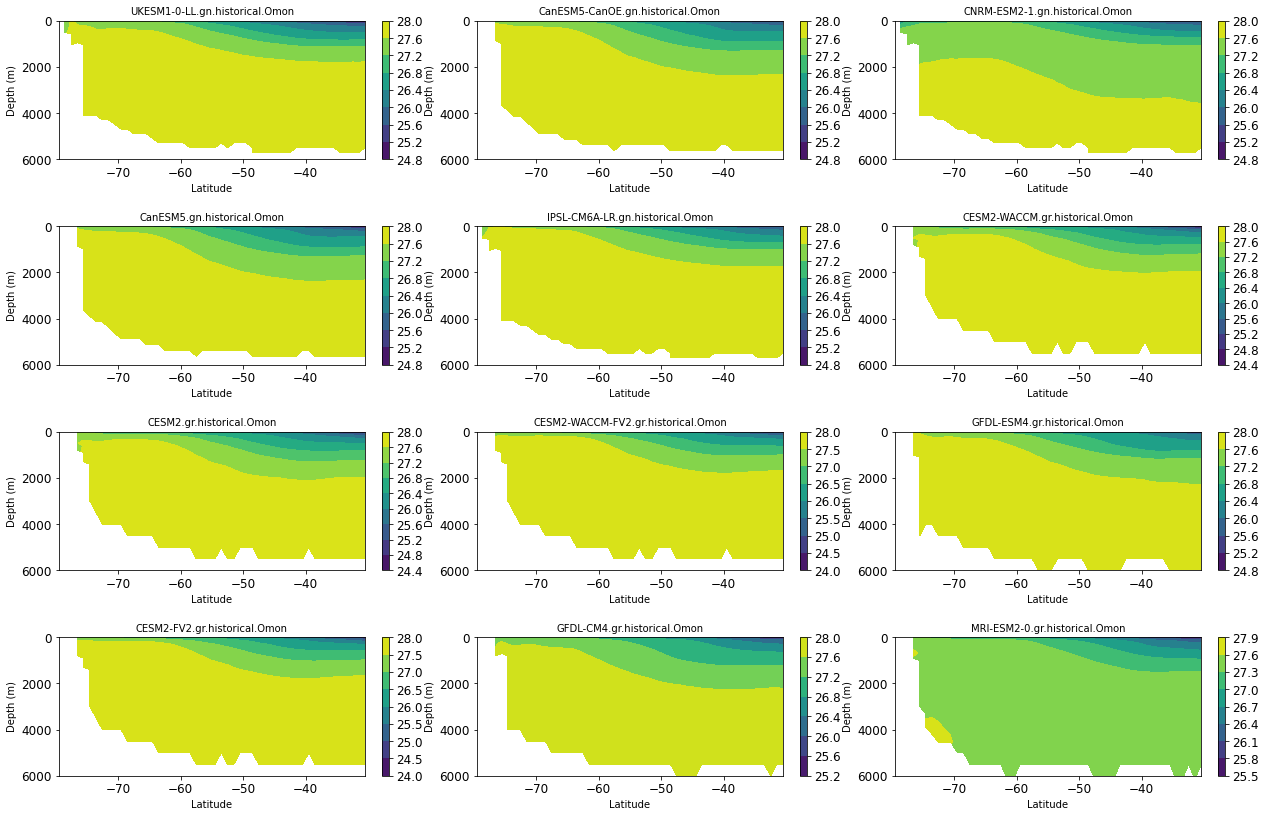

In [21]:
#You dont have to spell out all the axes, you can just keep them in an array
fig_so, axarr_so = plt.subplots(nrows = 4, ncols = 3,figsize=[18,12])
fig_so.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds in dd.items():
#     print(ds)
    ax = axarr_so.flat[ax_idx]
    ds = ds.mean('x', keep_attrs = True)
    im = ax.contourf(ds.y, ds.lev, ds.sigma0)
    # ax.set_title(ds.attrs['source_id']+ ' '+ds.attrs['variant_label'])
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Depth (m)')
    ax.set_ylim([6000, 0])
    cbar = plt.colorbar(im,ax = ax,fraction = 0.05, pad=0.05)
    ax.set_title(name)
    #ax.set_xlim([-90, 90])
#    #advance the axis index
    ax_idx += 1 # this is a nifty python trick to increment a variable by one

# Functions written by Graeme
I have added `areacello` to the functions

In [11]:
# Get some more grid information
# (and correct the lev variable
# so that it is actually between
# lev_bounds)

# Separately calculate dx and dy
def _degrees_to_meters(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters
        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values
        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        dx = dlon * np.cos(np.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

def get_xgcm(ds,gridlon='x',gridlat='y',gridlev='lev',periodic=None):
    ''' Generate metrics and grid locations'''

    ds = generate_grid_ds(ds, {'X':gridlon,'Y':gridlat})
    xgrid = Grid(ds, periodic=periodic)

    # Get horizontal distances
    dlonG = xgrid.diff(ds[gridlon], 'X', boundary_discontinuity=360)
    dlonC = xgrid.diff(ds[gridlon+'_left'], 'X', boundary_discontinuity=360)

    dlatG = xgrid.diff(ds[gridlat], 'Y', boundary='fill', fill_value=np.nan)
    dlatC = -xgrid.diff(ds[gridlat+'_left'], 'Y', boundary='fill', fill_value=np.nan)

    ds['dxG'], ds['dyG'] = _degrees_to_meters(dlonG, dlatG, ds[gridlon], ds[gridlat])
    ds['dxC'], ds['dyC'] = _degrees_to_meters(dlonC, dlatC, ds[gridlon], ds[gridlat])
    
    # Get vertical distances
    ds['dz'] = ds['lev_bounds'].diff('bnds').squeeze()
    
    # Get area
    ds['areacello'] = ds['dxC']*ds['dyC']
    
    # Regenerate grid
    coords = {
        'X':{'center':gridlon,'left':gridlon+'_left'},
        'Y':{'center':gridlat,'left':gridlat+'_left'},
        'Z':{'center':gridlev,'outer':gridlev+'_outer'}
    }
    metrics = {
        'X':['dxC','dxG'],
        'Y':['dyC','dyG'],
        'Z':['dz'],
        ('X','Y'):['areacello']
    }
    
    xgrid = Grid(ds,coords=coords,metrics=metrics,periodic=periodic)
    
    return ds,xgrid

def get_xgcm_special(ds,gridlon='x',gridlat='y',gridlev='lev',periodic=None):
    ''' Generate metrics and grid locations
        This is a hacked version to specify "outer" coordinates for y,
        for use with transform method.'''

    ds = generate_grid_ds(ds, {'X':gridlon,'Y':gridlat})
    lat_left = np.append(ds[gridlat+'_left'],ds[gridlat+'_left'].isel(y_left=-1)+1)
    ds = ds.assign_coords({gridlat+'_left':lat_left})
    coords = {
        'X':{'center':gridlon,'left':gridlon+'_left'},
        'Y':{'center':gridlat,'outer':gridlat+'_left'}
    }
    xgrid = Grid(ds, coords=coords, periodic=periodic)

    # Get horizontal distances
    dlonG = xgrid.diff(ds[gridlon], 'X', boundary_discontinuity=360)
    dlonC = xgrid.diff(ds[gridlon+'_left'], 'X', boundary_discontinuity=360)

    dlatG = xgrid.diff(ds[gridlat], 'Y', boundary='fill', fill_value=np.nan)
    dlatC = -xgrid.diff(ds[gridlat+'_left'], 'Y', boundary='fill', fill_value=np.nan)

    ds['dxG'], ds['dyG'] = _degrees_to_meters(dlonG, dlatG, ds[gridlon], ds[gridlat])
    ds['dxC'], ds['dyC'] = _degrees_to_meters(dlonC, dlatC, ds[gridlon], ds[gridlat])
    
    # Get vertical distances
    ds['dz'] = ds['lev_bounds'].diff('bnds').squeeze()
    
    # get area
    ds['areacello'] = ds['dxC']*ds['dyC']
    
    # Regenerate grid
    coords = {
        'X':{'center':gridlon,'outer':gridlon+'_left'},
        'Y':{'center':gridlat,'outer':gridlat+'_left'},
        'Z':{'center':gridlev,'outer':gridlev+'_outer'}
    }
    metrics = {
        'X':['dxC','dxG'],
        'Y':['dyC','dyG'],
        'Z':['dz'],
        ('X','Y'):['areacello']
    }
    
    xgrid = Grid(ds,coords=coords,metrics=metrics,periodic=periodic)
    
    return ds,xgrid
# # Get center and outer z coords
# ds['lev'] = ds['lev_bounds'].mean('bnds').values
# ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

# # Generate xgcm grid
# ds,xgrid = get_xgcm_special(ds,periodic='X')
# # Create a 3d version of dz
# ds['dz3d']=ds['dz']*xr.ones_like(ds['talk'])

# `PCO2` on `sigma0`
Stuff starts looking funky here, particularly for CanESM5 and GFDL models

## For densities between 26 and 28

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.p

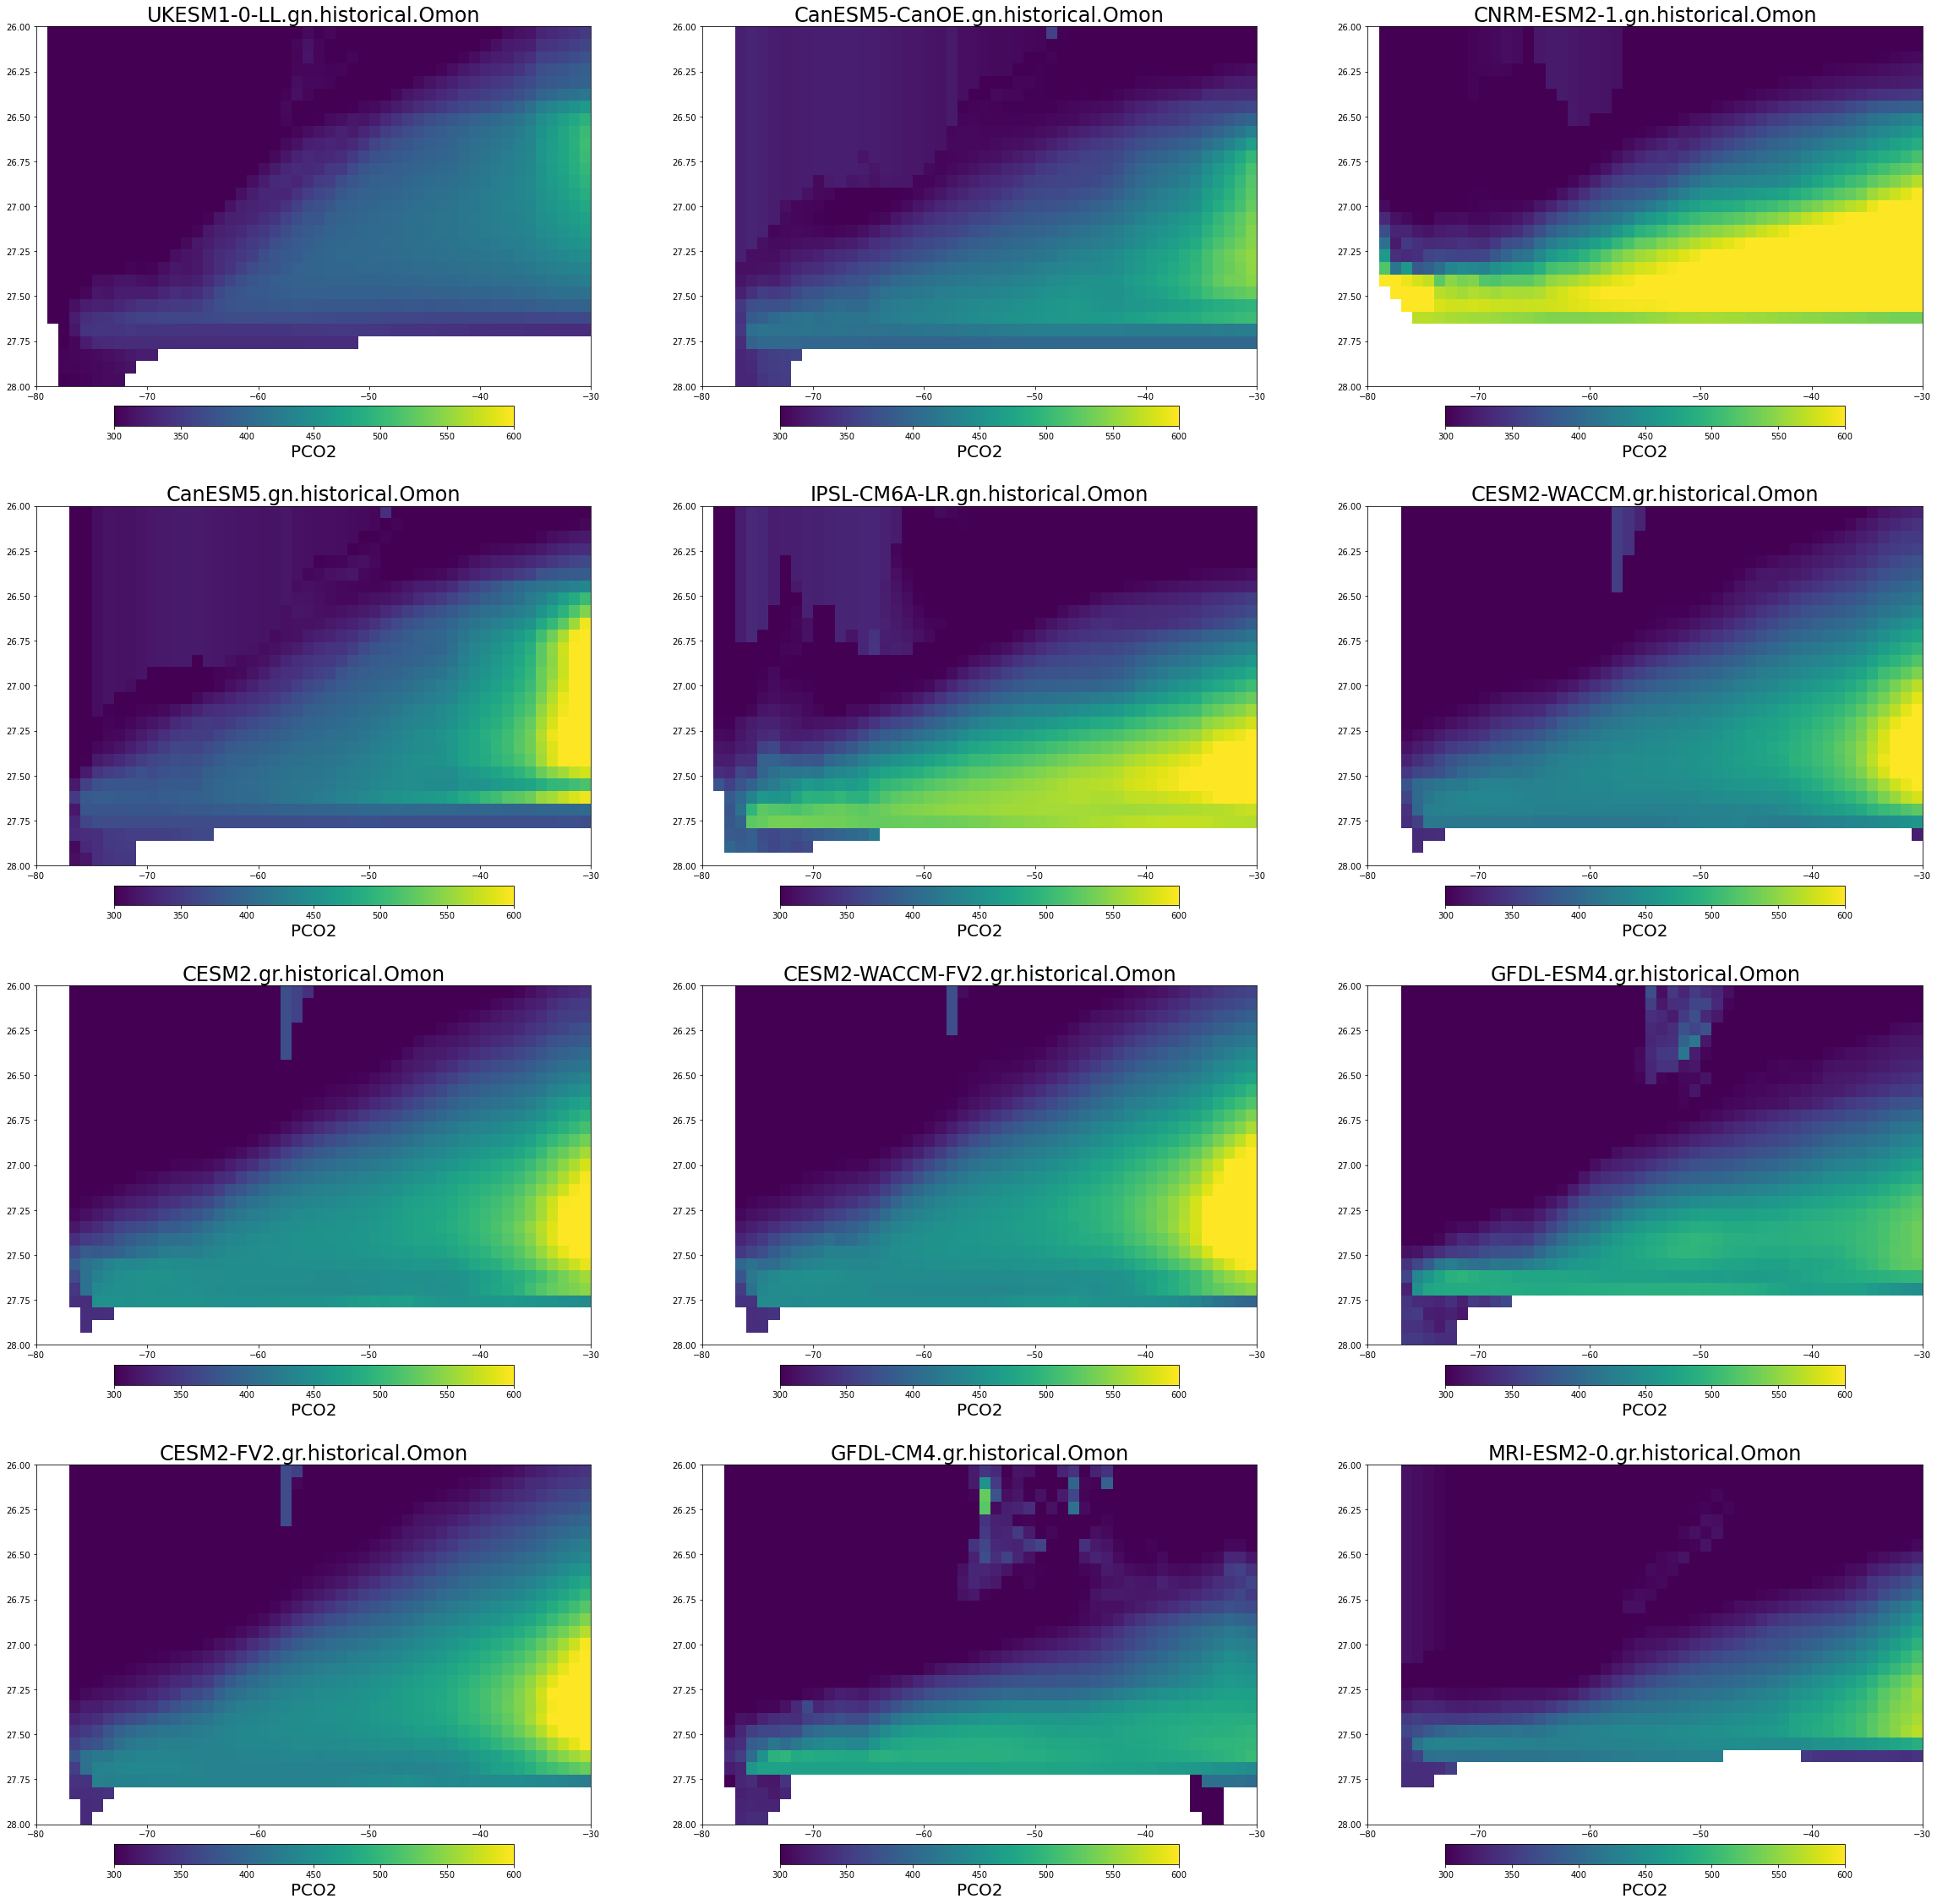

In [12]:
fig, axarr = plt.subplots(nrows = 4, ncols=3, figsize=[40,40])
target = np.linspace(26, 28, 30)
ax_idx = 0 # index for your axes array
for name, ds in dd.items():

    ax = axarr.flat[ax_idx]
    
    # Get center and outer z coords
    ds['lev'] = ds['lev_bounds'].mean('bnds').values
    ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

    # Generate xgcm grid
    ds,xgrid = get_xgcm_special(ds,periodic='X')
    # Create a 3d version of dz
    ds['dz3d']=ds['dz']*xr.ones_like(ds['PCO2'])
    
    # Interpolate thetao onto lev_outer
    ds['sigma0_outer'] = xgrid.interp(ds['sigma0'], 'Z', boundary='fill')
    # Need to chunk in lev_outer dimension otherwise transform gets upset
    ds = ds.chunk({'lev_outer':-1})
    # Transform dz
    ds_t = xr.Dataset()
    ds_t['dz3d'] = xgrid.transform(ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer'])
    # Transform var*dz
    ds_t['PCO2-dz'] = xgrid.transform(ds['PCO2']*ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer'])

    # Now get dz-weighted mean in x
    ds_t['PCO2'] = ds_t['PCO2-dz'].sum('x')/ds_t['dz3d'].sum('x')
    im = ax.pcolormesh(ds_t['PCO2'].y, ds_t['PCO2'].sigma0_outer, ds_t['PCO2'].transpose('sigma0_outer', 'y'), vmin = 300, vmax = 600)
    ax.invert_yaxis()
    cbar = plt.colorbar(im,ax = ax, orientation='horizontal',fraction = 0.05, pad=0.05)
    cbar.set_label('PCO2', fontsize = 20)
    ax.set_title(name, fontsize = 24)
    ax_idx += 1

So I found the error in the last iteration of this that made GFDL and CanESM5 wacky. When loading the datasets for those, I selected only the upper 500 meters (artifact from a previous code). Now that I've fixed it, all the plots look reasonable

The greater density range is not necessarily more insightful. The only additional information that might be here is a water mass indicative of `PCO2` uptake in waters with densities closer to 25 

# `fgco2` on sigma0
this is an old cell block that i haven't rerun cause my code is shit and overwrites everything right now, so conversions and signs might be weird but the point is that it plots *something*

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.p

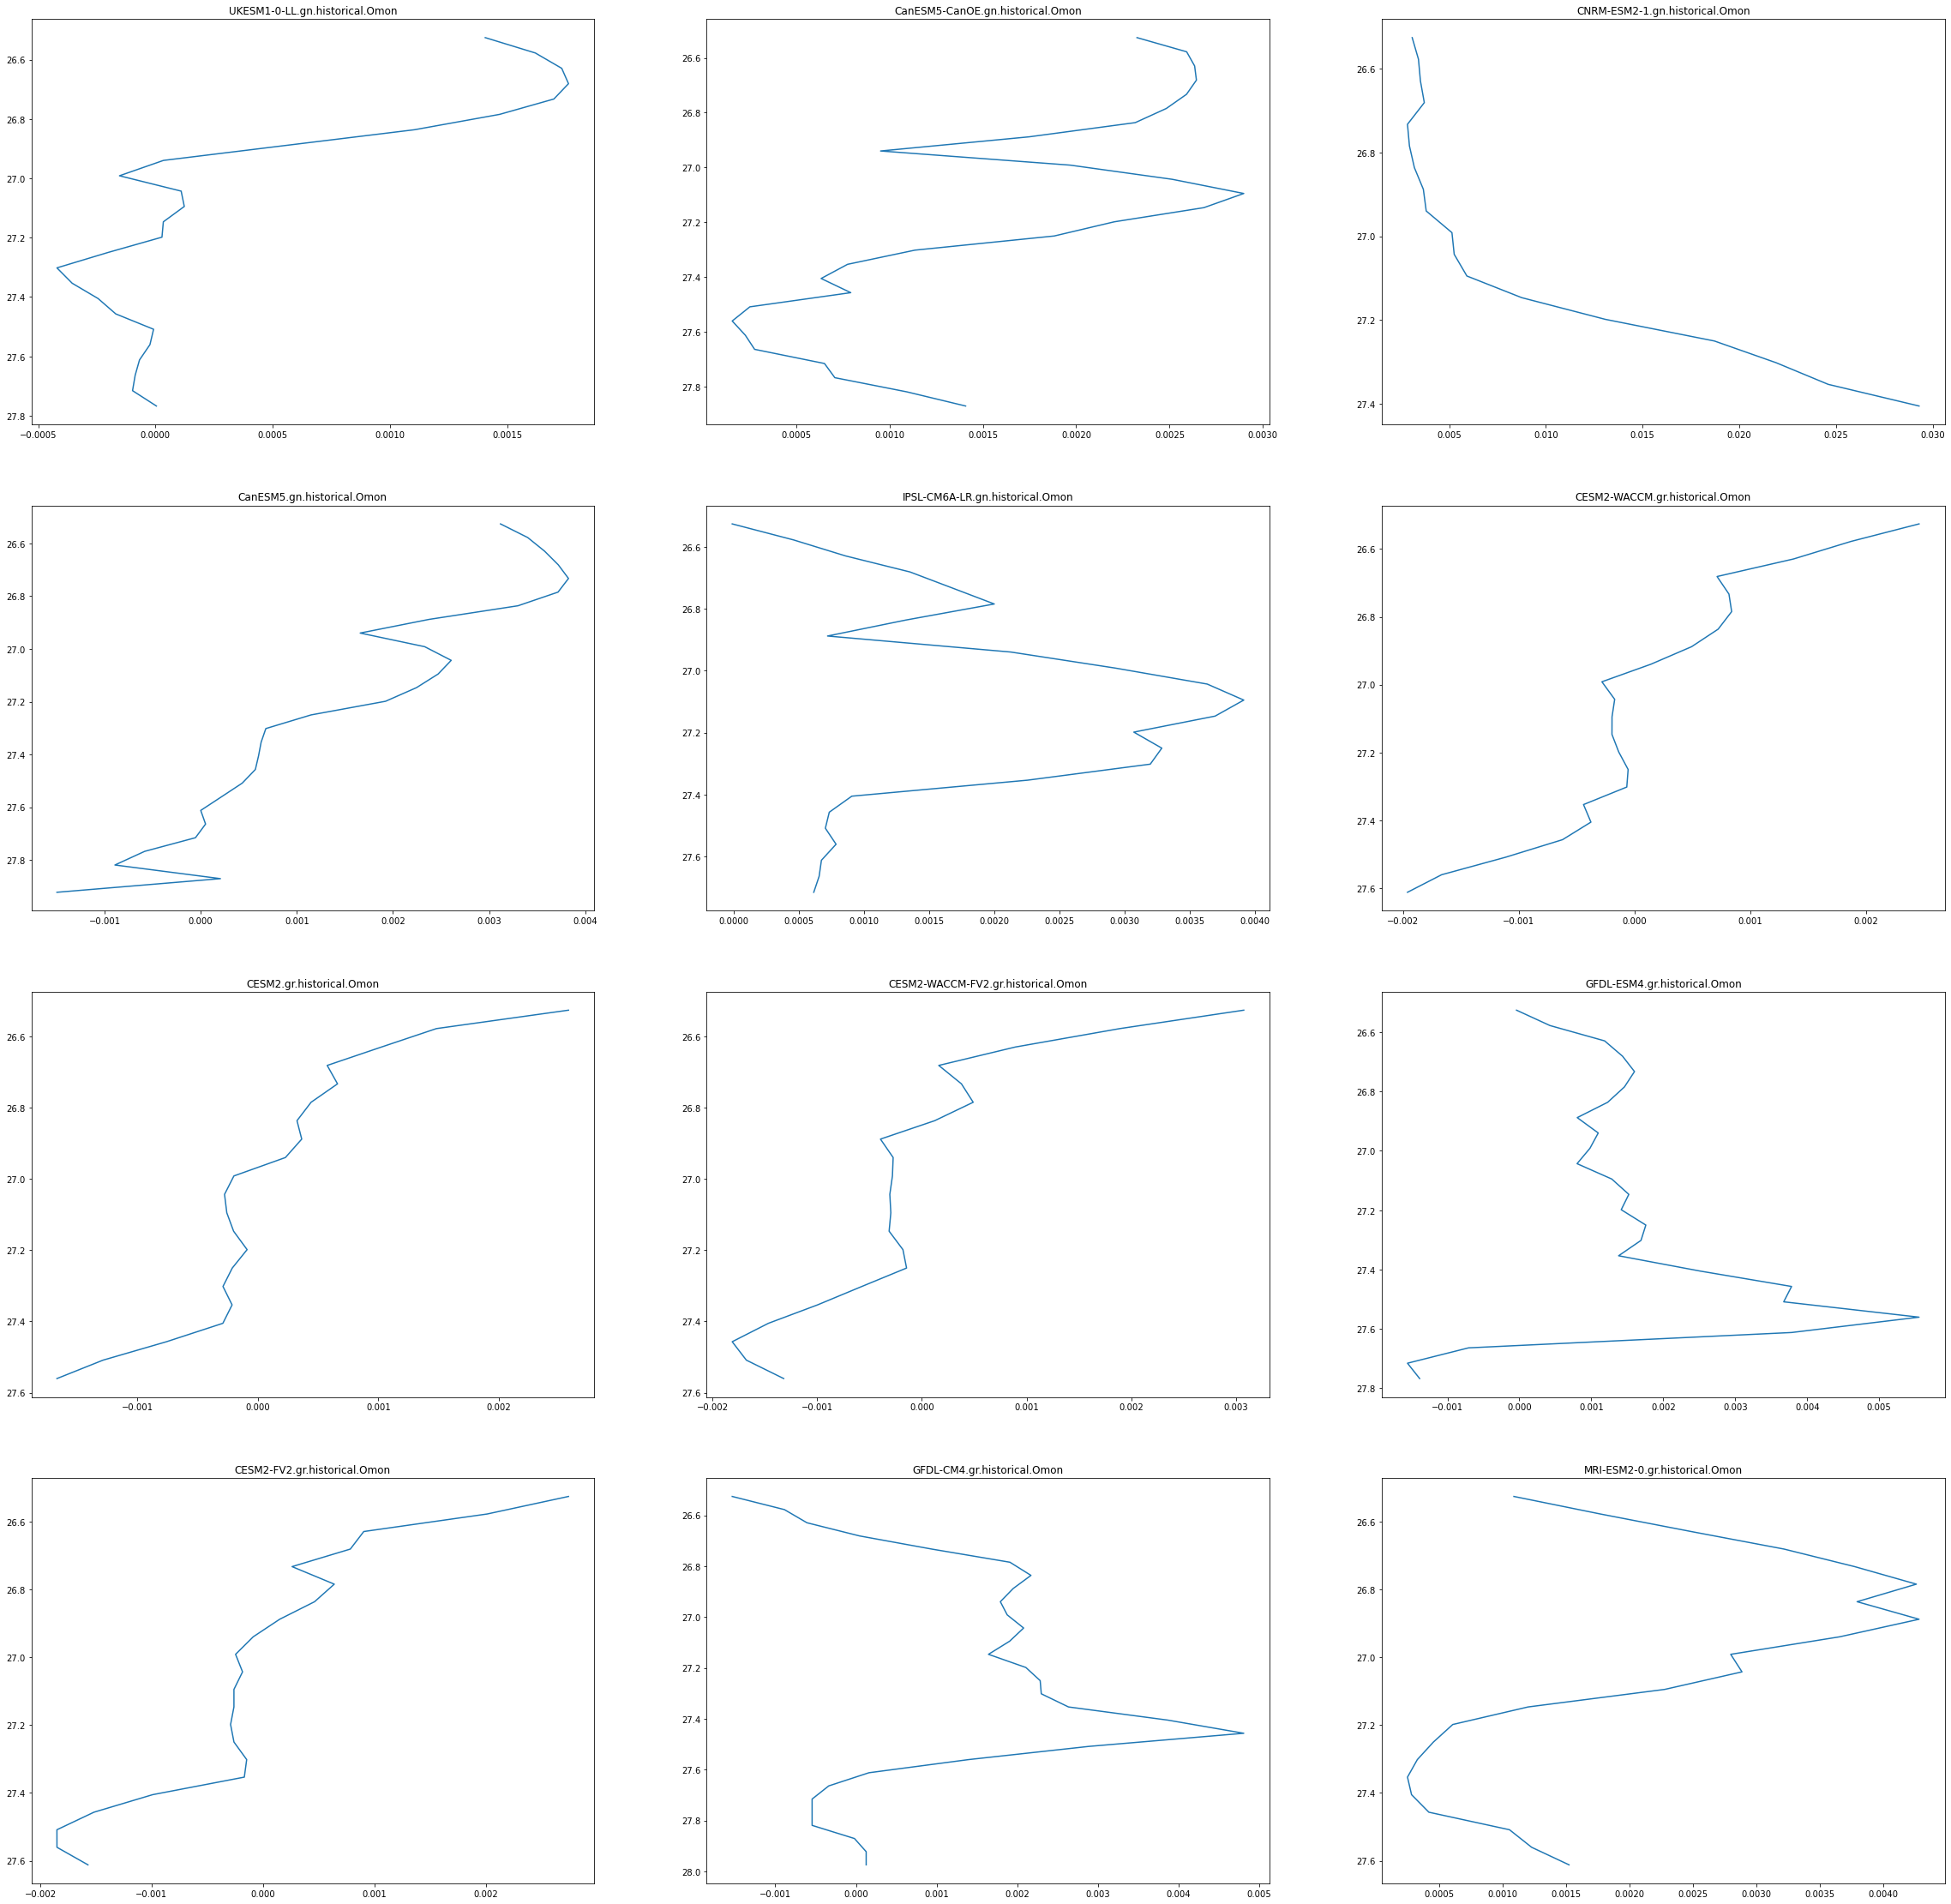

In [13]:
fig, axarr = plt.subplots(nrows = 4, ncols=3, figsize=[40,40])
target = np.linspace(26.5, 28, 30)
ax_idx = 0 # index for your axes array
for name, ds in dd.items():

    ax = axarr.flat[ax_idx]

    
    # Get center and outer z coords
    ds['lev'] = ds['lev_bounds'].mean('bnds').values
    ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

    # Generate xgcm grid
    ds,xgrid = get_xgcm_special(ds,periodic='X')
    
    # Interpolate thetao onto y_left
    ds['sigma0_outer'] = xgrid.interp(ds['sigma0'], 'Y', boundary='fill')
    # Need to chunk in lev_outer dimension otherwise transform gets upset
    ds = ds.chunk({'y_left':-1})
    # Transform areacello
    ds_t = xr.Dataset()
    ds_t['areacello'] = xgrid.transform(ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer'].isel(lev=0))
    # Transform var * areacello
    ds_t['fgco2-areacello'] = xgrid.transform(ds['fgco2']*ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer'].isel(lev=0))

    # Now get dz-weighted mean in x
    ds_t['fgco2'] = ds_t['fgco2-areacello'].sum('x')/ds_t['areacello'].sum('x')
    ax.plot(ds_t['fgco2'], ds_t['fgco2'].sigma0_outer)
    ax.set_title(name)
    ax.invert_yaxis()
    ax_idx += 1


# `dd_transform`
maybe select `fgco2` for mixed layer density, where water is coming into the mixed layer

In [14]:
dd_transform = {} 
target = np.linspace(26, 28, 60)

for name, ds in dd.items():
    
    # Get center and outer z coords
    ds['lev'] = ds['lev_bounds'].mean('bnds').values
    ds['lev_outer'] = np.append(ds['lev_bounds'].isel(bnds=0),ds['lev_bounds'].isel(lev=-1,bnds=-1))

    # Generate xgcm grid
    # I think it is ok to overwrite xgrid since everything I need xgrid for is in this cell block
    ds,xgrid = get_xgcm_special(ds,periodic='X')
    
    # Create a 3d version of dz
    ds['dz3d']=ds['dz']*xr.ones_like(ds['PCO2'])

    # Interpolate thetao onto lev_outer
    ds['sigma0_outer3d'] = xgrid.interp(ds['sigma0'], 'Z', boundary='fill')
    ds['sigma0_outer2d'] = xgrid.interp(ds['sigma0'], 'Y', boundary='fill')
    
    # Need to chunk in lev_outer dimension otherwise transform gets upset
    ds = ds.chunk({'lev_outer':-1})


    # Transform dz
    dd_transform[name] = {}
    ds_transform = xr.Dataset()
    ds_transform['dz3d'] = xgrid.transform(ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])
    # Transform var*dz
    ds_transform['PCO2-dz'] = xgrid.transform(ds['PCO2']*ds['dz3d'],
                             'Z',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer3d'])

    # Now get dz-weighted mean in x
    ds_transform['PCO2'] = ds_transform['PCO2-dz'].sum('x')/ds_transform['dz3d'].sum('x')
    # ax2.set_title('CESM2-FV2.gr.historical.Omon')

    ds = ds.chunk({'y_left':-1})
    # ds_t = xr.Dataset()
    ds_transform['areacello'] = xgrid.transform(ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))
    # Transform var * areacello
    ds_transform['fgco2-areacello'] = xgrid.transform(ds['fgco2']*ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))

    # Now get dz-weighted mean in x
    ds_transform['fgco2'] = ds_transform['fgco2-areacello'].sum('x')/ds_transform['areacello'].sum('x')
    
    present = ds.data_vars
    if 'hfds' in present:
        ds_transform['hfds-areacello'] = xgrid.transform(ds['hfds']*ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))

    # Now get dz-weighted mean in x
        ds_transform['hfds'] = ds_transform['hfds-areacello'].sum('x')/ds_transform['areacello'].sum('x')
        
    if 'intpp' in present:
        ds_transform['intpp-areacello'] = xgrid.transform(ds['intpp']*ds['areacello'],
                             'Y',
                             target,
                             method='conservative',
                             target_data=ds['sigma0_outer2d'].isel(lev=0))

    # Now get dz-weighted mean in x
        ds_transform['intpp'] = ds_transform['intpp-areacello'].sum('x')/ds_transform['areacello'].sum('x')
    
    # present = ds.data_vars
    # if 'mlotst' in present:
    #     ds.sigma0.sel(lev = ds.mlotst, method = 'nearest').mean('x', keep_attrs = True)
    
    
    dd_transform[name] = ds_transform 

/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.9/site-packages/xgcm/transform.py:235: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/srv

In [15]:
dd_transform

{'UKESM1-0-LL.gn.historical.Omon': <xarray.Dataset>
 Dimensions:          (y: 50, x: 360, sigma0_outer3d: 59, sigma0_outer2d: 59)
 Coordinates:
     lon              (y, x) float64 dask.array<chunksize=(50, 360), meta=np.ndarray>
     lat              (y, x) float64 dask.array<chunksize=(50, 360), meta=np.ndarray>
   * x                (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
   * y                (y) float64 -79.5 -78.5 -77.5 -76.5 ... -32.5 -31.5 -30.5
   * sigma0_outer3d   (sigma0_outer3d) float64 26.02 26.05 26.08 ... 27.95 27.98
     lev              float64 0.512
   * sigma0_outer2d   (sigma0_outer2d) float64 26.02 26.05 26.08 ... 27.95 27.98
 Data variables:
     dz3d             (y, x, sigma0_outer3d) float64 dask.array<chunksize=(50, 360, 59), meta=np.ndarray>
     PCO2-dz          (y, x, sigma0_outer3d) float64 dask.array<chunksize=(50, 360, 59), meta=np.ndarray>
     PCO2             (y, sigma0_outer3d) float64 dask.array<chunksize=(50, 59), meta=np.ndarra

# Now plotting things together
Admittedly it is very hacky. I'm constantly overwriting `ds_t` because I'm not sure what I ideally want in that. I'm also not sure how to treat `xgrid.interp('Z')` and `xgrid.interp('Y')` and have them happen at the same time???

ugh also now realizing that the way `ds_t` is set up (meaning it doesn't have model name keys) means I can't conveniently throw in `**model_kwargs`. So I need to figure out how to get like a "master" `ds_t` that has the model key and contains all the info I need and isn't constantly overwritten


## CESM2-FV2
`color = '#024c8f'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


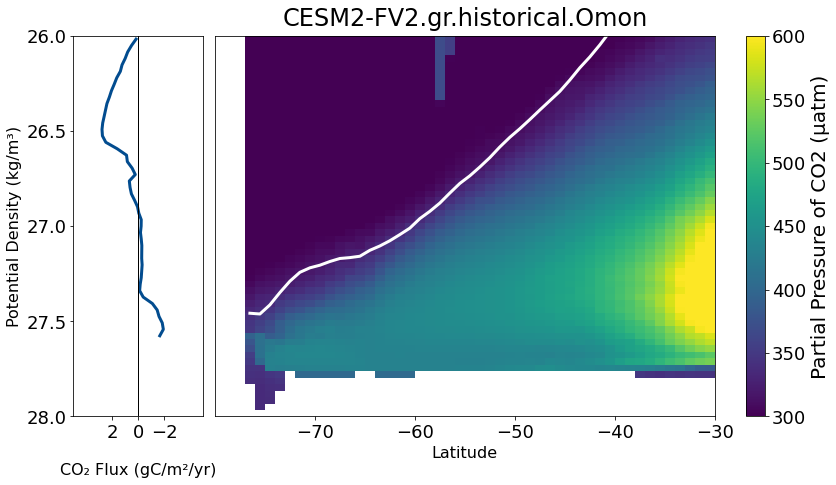

In [83]:
ds = dd_transform['CESM2-FV2.gr.historical.Omon']
name = 'CESM2-FV2.gr.historical.Omon'
fig = plt.figure(figsize=(15, 7)) 
select = {'y':slice(-80,-30)}
con_pos = np.linspace(0, 2e8, 10)
plt.rc('font', size = 18)
plt.rc('axes', titlesize= 24)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=20)

# axes
axco2 = plt.subplot2grid((6,12), (0,0), rowspan = 6, colspan = 2)
axPCO2 = plt.subplot2grid((6,12), (0, 2), rowspan = 6, colspan = 9)
# axSI = plt.subplot2grid((6,17), (0, 6), rowspan = 1, colspan = 9)
# axhfds = plt.subplot2grid((6,17), (1, 0), rowspan = 5, colspan = 2)
# axintpp = plt.subplot2grid((6,17), (1, 2), rowspan = 5, colspan = 2)
plt.subplots_adjust(hspace=0.2)
axintpp.set_title('CESM2-FV2.gr.historical.Omon', fontsize = 16, pad = 30)

# co2
# plotting outgassing in red and ingassing  in blue
axco2.plot(ds.fgco2*1e3, ds.sigma0_outer2d, lw = 3, **model_kwargs[name])
# axco2.plot(ds.fgco2.where(ds.fgco2>=0)*1e3, ds.sigma0_outer2d, color =  'r')
# axco2.plot(ds.fgco2.where(ds.fgco2<=0)*1e3, ds.sigma0_outer2d, color =  'b')
axco2.axvline(x=0, color = 'k', lw = 1)
axco2.set_xticks([-2,0,2])
axco2.set_xlim([-5,5])
# axco2.set_xticklabels([-2,0,2], fontsize = 16)
axco2.set_yticks([26, 26.5, 27, 27.5, 28])
# axco2.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
axco2.set_ylim([26, 28])
axco2.set_xlabel('\nCO\u2082 Flux (gC/m\u00b2/yr)')
axco2.set_ylabel('Potential Density (kg/m\u00b3)')
axco2.invert_yaxis()
axco2.invert_xaxis()

# PCO2
im = axPCO2.pcolormesh(ds.y, ds.sigma0_outer3d, ds['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
cbar_label = 'Partial Pressure of CO2 (\u03BCatm)'
cbar = plt.colorbar(im,ax = axPCO2)
cbar.set_label(cbar_label, fontsize = 20)
# axPCO2.contour(psids.y, psids.sigma0,psids.transpose(),linestyles = 'solid', colors = 'k')
axPCO2.set_yticks([])
axPCO2.set_xticks([-70, -60, -50, -40, -30])
# axPCO2.set_xticklabels([-70, -60, -50, -40, -30], fontsize = 14)
axPCO2.set_ylim([26, 28])
axPCO2.invert_yaxis()
axPCO2.set_xlabel('Latitude')
axPCO2.set_title(name, pad = 10)

# mixed layer
da = dd[name]
present = da.data_vars
if 'mlotst' in present:
    axPCO2.plot(da.y, da.sigma0.sel(lev = da.mlotst, method = 'nearest').mean('x', keep_attrs = True), color = 'w', lw = 3)

# # intpp
# # all values in blue since PP consumes carbon
# present = ds.data_vars
# if 'intpp' in present:
#     axintpp.plot(ds.intpp, ds.sigma0_outer2d, color = 'b')
#     axintpp.set_yticks([])
#     axintpp.set_yticklabels([], fontsize = 16)
#     axintpp.set_ylim([26, 28])
#     axintpp.invert_yaxis()
#     axintpp.set_xlabel('PP')

# # heat flux
# # blue for negative, red for positive
# if 'hfds' in present:
#     axhfds.plot(ds.hfds.where(ds.hfds>=0), ds.sigma0_outer2d, color = 'r')
#     axhfds.plot(ds.hfds.where(ds.hfds<=0), ds.sigma0_outer2d, color = 'b')
#     axhfds.set_yticks([26, 26.5, 27, 27.5, 28])
#     # axhfds.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
#     axhfds.set_ylim([26, 28])
#     axhfds.invert_yaxis()
#     axhfds.set_ylabel('Potential Density')
#     axhfds.set_xlabel('Heat Flux')

# # switch y ticks to the right side for space
# axS.yaxis.tick_right()



## CNRM-ESM2-1
`color = '#cc0000'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


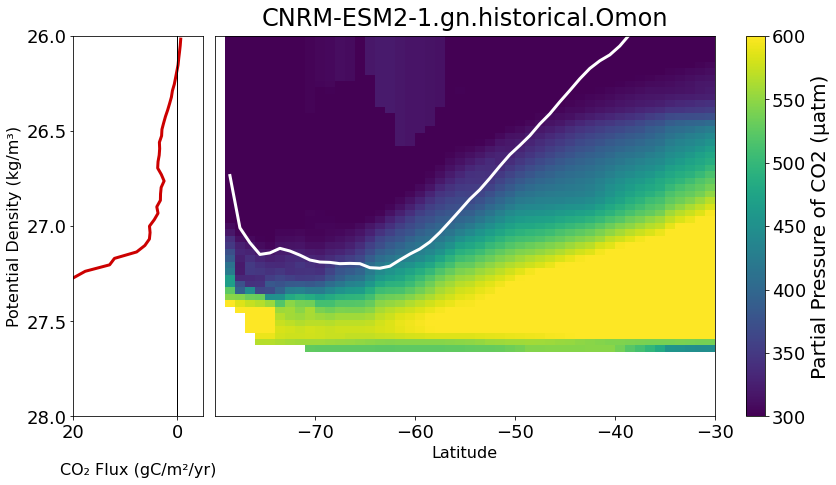

In [84]:
ds = dd_transform['CNRM-ESM2-1.gn.historical.Omon']
name = 'CNRM-ESM2-1.gn.historical.Omon'
fig = plt.figure(figsize=(15, 7)) 
select = {'y':slice(-80,-30)}
con_pos = np.linspace(0, 2e8, 10)
plt.rc('font', size = 18)
plt.rc('axes', titlesize= 24)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=20)

# axes
axco2 = plt.subplot2grid((6,12), (0,0), rowspan = 6, colspan = 2)
axPCO2 = plt.subplot2grid((6,12), (0, 2), rowspan = 6, colspan = 9)
# axSI = plt.subplot2grid((6,17), (0, 6), rowspan = 1, colspan = 9)
# axhfds = plt.subplot2grid((6,17), (1, 0), rowspan = 5, colspan = 2)
# axintpp = plt.subplot2grid((6,17), (1, 2), rowspan = 5, colspan = 2)
plt.subplots_adjust(hspace=0.2)
# axintpp.set_title('CESM2-FV2.gr.historical.Omon', fontsize = 16, pad = 30)

# co2
# plotting outgassing in red and ingassing  in blue
axco2.plot(ds.fgco2*1e3, ds.sigma0_outer2d, lw = 3, **model_kwargs[name])
# axco2.plot(ds.fgco2.where(ds.fgco2>=0)*1e3, ds.sigma0_outer2d, color =  'r')
# axco2.plot(ds.fgco2.where(ds.fgco2<=0)*1e3, ds.sigma0_outer2d, color =  'b')
axco2.axvline(x=0, color = 'k', lw = 1)
# axco2.set_xticks([-2,0,2])
axco2.set_xlim([-5,20])
# axco2.set_xticklabels([-2,0,2], fontsize = 16)
axco2.set_yticks([26, 26.5, 27, 27.5, 28])
# axco2.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
axco2.set_ylim([26, 28])
axco2.set_xlabel('\nCO\u2082 Flux (gC/m\u00b2/yr)')
axco2.set_ylabel('Potential Density (kg/m\u00b3)')
axco2.invert_yaxis()
axco2.invert_xaxis()

# PCO2
im = axPCO2.pcolormesh(ds.y, ds.sigma0_outer3d, ds['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
cbar_label = 'Partial Pressure of CO2 (\u03BCatm)'
cbar = plt.colorbar(im,ax = axPCO2)
cbar.set_label(cbar_label, fontsize = 20)
# axPCO2.contour(psids.y, psids.sigma0,psids.transpose(),linestyles = 'solid', colors = 'k')
axPCO2.set_yticks([])
axPCO2.set_xticks([-70, -60, -50, -40, -30])
# axPCO2.set_xticklabels([-70, -60, -50, -40, -30], fontsize = 14)
axPCO2.set_ylim([26, 28])
axPCO2.invert_yaxis()
axPCO2.set_xlabel('Latitude')
axPCO2.set_title(name, pad = 10)

# mixed layer
da = dd[name]
present = da.data_vars
if 'mlotst' in present:
    axPCO2.plot(da.y, da.sigma0.sel(lev = da.mlotst, method = 'nearest').mean('x', keep_attrs = True), color = 'w', lw = 3)


No CO2 uptake in this density range????

## CanESM5-CanOE
`color = '#a1a1a1'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


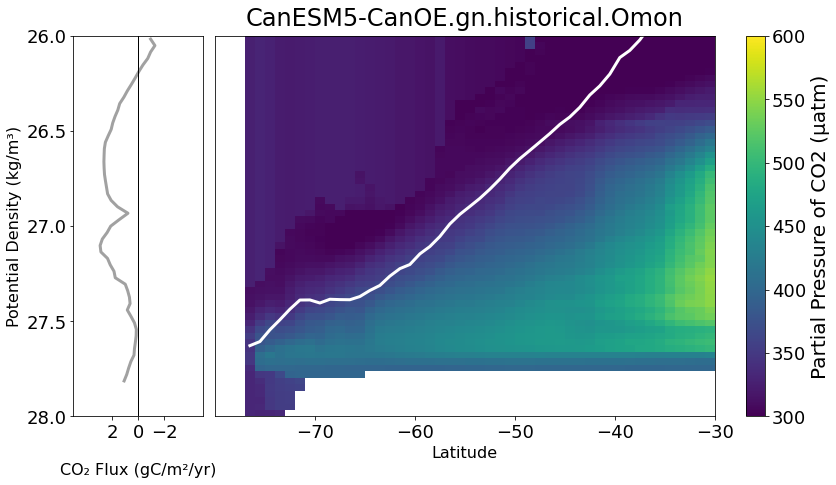

In [85]:
ds = dd_transform['CanESM5-CanOE.gn.historical.Omon']
name = 'CanESM5-CanOE.gn.historical.Omon'
fig = plt.figure(figsize=(15, 7)) 
select = {'y':slice(-80,-30)}
con_pos = np.linspace(0, 2e8, 10)
plt.rc('font', size = 18)
plt.rc('axes', titlesize= 24)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=20)

# axes
axco2 = plt.subplot2grid((6,12), (0,0), rowspan = 6, colspan = 2)
axPCO2 = plt.subplot2grid((6,12), (0, 2), rowspan = 6, colspan = 9)
# axSI = plt.subplot2grid((6,17), (0, 6), rowspan = 1, colspan = 9)
# axhfds = plt.subplot2grid((6,17), (1, 0), rowspan = 5, colspan = 2)
# axintpp = plt.subplot2grid((6,17), (1, 2), rowspan = 5, colspan = 2)
plt.subplots_adjust(hspace=0.2)
# axintpp.set_title('CESM2-FV2.gr.historical.Omon', fontsize = 16, pad = 30)

# co2
# plotting outgassing in red and ingassing  in blue
axco2.plot(ds.fgco2*1e3, ds.sigma0_outer2d, lw = 3, **model_kwargs[name])
# axco2.plot(ds.fgco2.where(ds.fgco2>=0)*1e3, ds.sigma0_outer2d, color =  'r')
# axco2.plot(ds.fgco2.where(ds.fgco2<=0)*1e3, ds.sigma0_outer2d, color =  'b')
axco2.axvline(x=0, color = 'k', lw = 1)
axco2.set_xticks([-2,0,2])
axco2.set_xlim([-5,5])
# axco2.set_xticklabels([-2,0,2], fontsize = 16)
axco2.set_yticks([26, 26.5, 27, 27.5, 28])
# axco2.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
axco2.set_ylim([26, 28])
axco2.set_xlabel('\nCO\u2082 Flux (gC/m\u00b2/yr)')
axco2.set_ylabel('Potential Density (kg/m\u00b3)')
axco2.invert_yaxis()
axco2.invert_xaxis()

# PCO2
im = axPCO2.pcolormesh(ds.y, ds.sigma0_outer3d, ds['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
cbar_label = 'Partial Pressure of CO2 (\u03BCatm)'
cbar = plt.colorbar(im,ax = axPCO2)
cbar.set_label(cbar_label, fontsize = 20)
# axPCO2.contour(psids.y, psids.sigma0,psids.transpose(),linestyles = 'solid', colors = 'k')
axPCO2.set_yticks([])
axPCO2.set_xticks([-70, -60, -50, -40, -30])
# axPCO2.set_xticklabels([-70, -60, -50, -40, -30], fontsize = 14)
axPCO2.set_ylim([26, 28])
axPCO2.invert_yaxis()
axPCO2.set_xlabel('Latitude')
axPCO2.set_title(name, pad = 10)

# mixed layer
da = dd[name]
present = da.data_vars
if 'mlotst' in present:
    axPCO2.plot(da.y, da.sigma0.sel(lev = da.mlotst, method = 'nearest').mean('x', keep_attrs = True), color = 'w', lw = 3)


recalling that CanESM5 models have high total outgassing, something makes sense about how much CO2 is outgassed in this persepctive. TBD what makes sense to me but *something*

## GFDL-ESM4
`color = '#674ea7'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


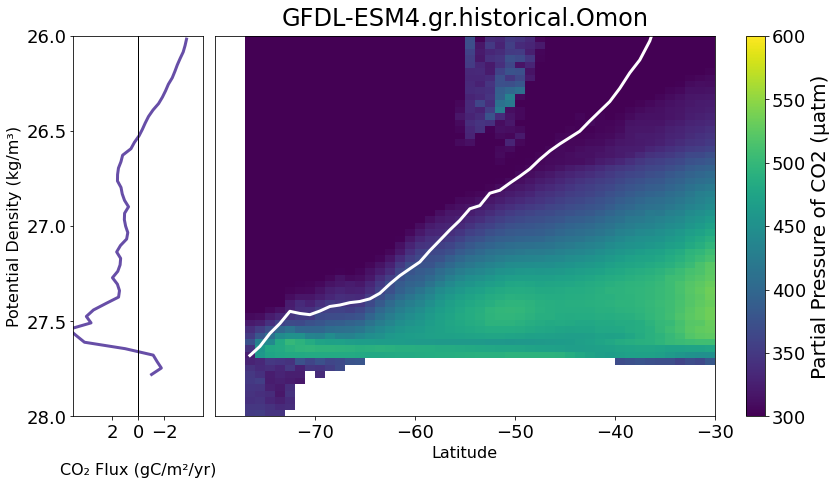

In [86]:
ds = dd_transform['GFDL-ESM4.gr.historical.Omon']
name = 'GFDL-ESM4.gr.historical.Omon'
fig = plt.figure(figsize=(15, 7)) 
select = {'y':slice(-80,-30)}
con_pos = np.linspace(0, 2e8, 10)
plt.rc('font', size = 18)
plt.rc('axes', titlesize= 24)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=20)

# axes
axco2 = plt.subplot2grid((6,12), (0,0), rowspan = 6, colspan = 2)
axPCO2 = plt.subplot2grid((6,12), (0, 2), rowspan = 6, colspan = 9)
# axSI = plt.subplot2grid((6,17), (0, 6), rowspan = 1, colspan = 9)
# axhfds = plt.subplot2grid((6,17), (1, 0), rowspan = 5, colspan = 2)
# axintpp = plt.subplot2grid((6,17), (1, 2), rowspan = 5, colspan = 2)
plt.subplots_adjust(hspace=0.2)
# axintpp.set_title('CESM2-FV2.gr.historical.Omon', fontsize = 16, pad = 30)

# co2
# plotting outgassing in red and ingassing  in blue
axco2.plot(ds.fgco2*1e3, ds.sigma0_outer2d, lw = 3, **model_kwargs[name])
# axco2.plot(ds.fgco2.where(ds.fgco2>=0)*1e3, ds.sigma0_outer2d, color =  'r')
# axco2.plot(ds.fgco2.where(ds.fgco2<=0)*1e3, ds.sigma0_outer2d, color =  'b')
axco2.axvline(x=0, color = 'k', lw = 1)
axco2.set_xticks([-2,0,2])
axco2.set_xlim([-5,5])
# axco2.set_xticklabels([-2,0,2], fontsize = 16)
axco2.set_yticks([26, 26.5, 27, 27.5, 28])
# axco2.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
axco2.set_ylim([26, 28])
axco2.set_xlabel('\nCO\u2082 Flux (gC/m\u00b2/yr)')
axco2.set_ylabel('Potential Density (kg/m\u00b3)')
axco2.invert_yaxis()
axco2.invert_xaxis()

# PCO2
im = axPCO2.pcolormesh(ds.y, ds.sigma0_outer3d, ds['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
cbar_label = 'Partial Pressure of CO2 (\u03BCatm)'
cbar = plt.colorbar(im,ax = axPCO2)
cbar.set_label(cbar_label, fontsize = 20)
# axPCO2.contour(psids.y, psids.sigma0,psids.transpose(),linestyles = 'solid', colors = 'k')
axPCO2.set_yticks([])
axPCO2.set_xticks([-70, -60, -50, -40, -30])
# axPCO2.set_xticklabels([-70, -60, -50, -40, -30], fontsize = 14)
axPCO2.set_ylim([26, 28])
axPCO2.invert_yaxis()
axPCO2.set_xlabel('Latitude')
axPCO2.set_title(name, pad = 10)

# mixed layer
da = dd[name]
present = da.data_vars
if 'mlotst' in present:
    axPCO2.plot(da.y, da.sigma0.sel(lev = da.mlotst, method = 'nearest').mean('x', keep_attrs = True), color = 'w', lw = 3)


weird.......

## IPSL-CM6A-LR
`color = '#f1c232'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


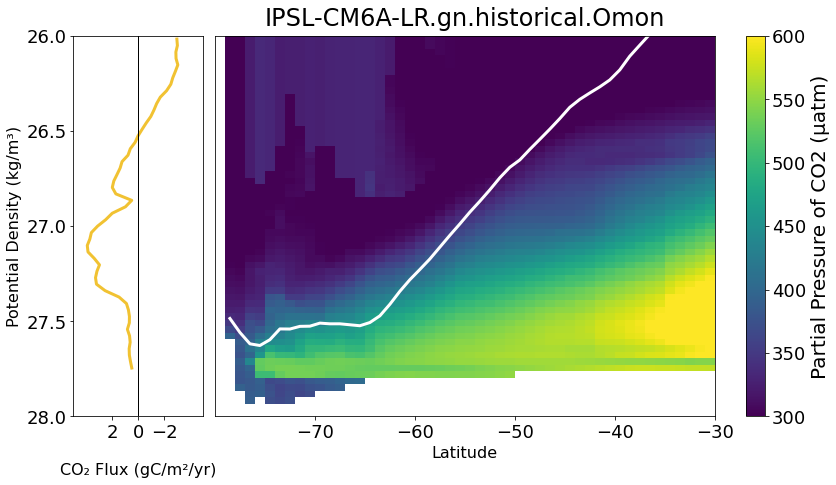

In [87]:
ds = dd_transform['IPSL-CM6A-LR.gn.historical.Omon']
name = 'IPSL-CM6A-LR.gn.historical.Omon'
fig = plt.figure(figsize=(15, 7)) 
select = {'y':slice(-80,-30)}
con_pos = np.linspace(0, 2e8, 10)
plt.rc('font', size = 18)
plt.rc('axes', titlesize= 24)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=20)

# axes
axco2 = plt.subplot2grid((6,12), (0,0), rowspan = 6, colspan = 2)
axPCO2 = plt.subplot2grid((6,12), (0, 2), rowspan = 6, colspan = 9)
# axSI = plt.subplot2grid((6,17), (0, 6), rowspan = 1, colspan = 9)
# axhfds = plt.subplot2grid((6,17), (1, 0), rowspan = 5, colspan = 2)
# axintpp = plt.subplot2grid((6,17), (1, 2), rowspan = 5, colspan = 2)
plt.subplots_adjust(hspace=0.2)
# axintpp.set_title('CESM2-FV2.gr.historical.Omon', fontsize = 16, pad = 30)

# co2
# plotting outgassing in red and ingassing  in blue
axco2.plot(ds.fgco2*1e3, ds.sigma0_outer2d, lw = 3, **model_kwargs[name])
# axco2.plot(ds.fgco2.where(ds.fgco2>=0)*1e3, ds.sigma0_outer2d, color =  'r')
# axco2.plot(ds.fgco2.where(ds.fgco2<=0)*1e3, ds.sigma0_outer2d, color =  'b')
axco2.axvline(x=0, color = 'k', lw = 1)
axco2.set_xticks([-2,0,2])
axco2.set_xlim([-5,5])
# axco2.set_xticklabels([-2,0,2], fontsize = 16)
axco2.set_yticks([26, 26.5, 27, 27.5, 28])
# axco2.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
axco2.set_ylim([26, 28])
axco2.set_xlabel('\nCO\u2082 Flux (gC/m\u00b2/yr)')
axco2.set_ylabel('Potential Density (kg/m\u00b3)')
axco2.invert_yaxis()
axco2.invert_xaxis()

# PCO2
im = axPCO2.pcolormesh(ds.y, ds.sigma0_outer3d, ds['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
cbar_label = 'Partial Pressure of CO2 (\u03BCatm)'
cbar = plt.colorbar(im,ax = axPCO2)
cbar.set_label(cbar_label, fontsize = 20)
# axPCO2.contour(psids.y, psids.sigma0,psids.transpose(),linestyles = 'solid', colors = 'k')
axPCO2.set_yticks([])
axPCO2.set_xticks([-70, -60, -50, -40, -30])
# axPCO2.set_xticklabels([-70, -60, -50, -40, -30], fontsize = 14)
axPCO2.set_ylim([26, 28])
axPCO2.invert_yaxis()
axPCO2.set_xlabel('Latitude')
axPCO2.set_title(name, pad = 10)

# mixed layer
da = dd[name]
present = da.data_vars
if 'mlotst' in present:
    axPCO2.plot(da.y, da.sigma0.sel(lev = da.mlotst, method = 'nearest').mean('x', keep_attrs = True), color = 'w', lw = 3)


I can make this one make sense in my head

## GFDL-CM4
`color = '#800080'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


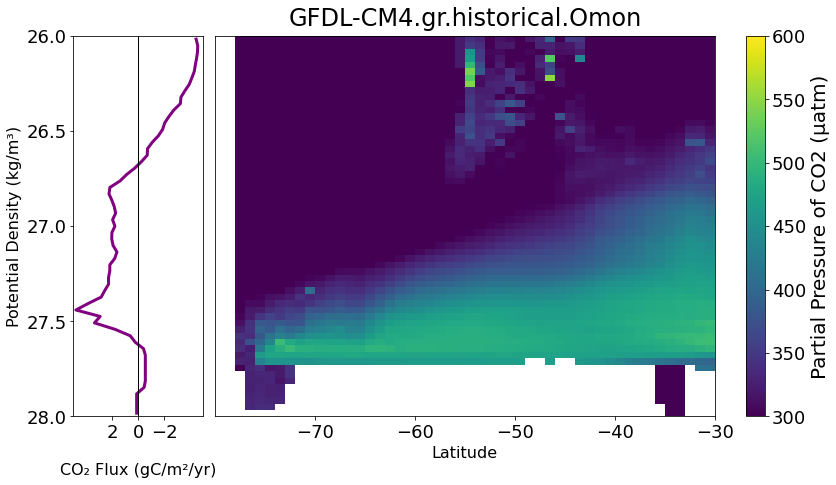

In [88]:
ds = dd_transform['GFDL-CM4.gr.historical.Omon']
name = 'GFDL-CM4.gr.historical.Omon'
fig = plt.figure(figsize=(15, 7)) 
select = {'y':slice(-80,-30)}
con_pos = np.linspace(0, 2e8, 10)
plt.rc('font', size = 18)
plt.rc('axes', titlesize= 24)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=20)

# axes
axco2 = plt.subplot2grid((6,12), (0,0), rowspan = 6, colspan = 2)
axPCO2 = plt.subplot2grid((6,12), (0, 2), rowspan = 6, colspan = 9)
# axSI = plt.subplot2grid((6,17), (0, 6), rowspan = 1, colspan = 9)
# axhfds = plt.subplot2grid((6,17), (1, 0), rowspan = 5, colspan = 2)
# axintpp = plt.subplot2grid((6,17), (1, 2), rowspan = 5, colspan = 2)
plt.subplots_adjust(hspace=0.2)
# axintpp.set_title('CESM2-FV2.gr.historical.Omon', fontsize = 16, pad = 30)

# co2
# plotting outgassing in red and ingassing  in blue
axco2.plot(ds.fgco2*1e3, ds.sigma0_outer2d, lw = 3, **model_kwargs[name])
# axco2.plot(ds.fgco2.where(ds.fgco2>=0)*1e3, ds.sigma0_outer2d, color =  'r')
# axco2.plot(ds.fgco2.where(ds.fgco2<=0)*1e3, ds.sigma0_outer2d, color =  'b')
axco2.axvline(x=0, color = 'k', lw = 1)
axco2.set_xticks([-2,0,2])
axco2.set_xlim([-5,5])
# axco2.set_xticklabels([-2,0,2], fontsize = 16)
axco2.set_yticks([26, 26.5, 27, 27.5, 28])
# axco2.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
axco2.set_ylim([26, 28])
axco2.set_xlabel('\nCO\u2082 Flux (gC/m\u00b2/yr)')
axco2.set_ylabel('Potential Density (kg/m\u00b3)')
axco2.invert_yaxis()
axco2.invert_xaxis()

# PCO2
im = axPCO2.pcolormesh(ds.y, ds.sigma0_outer3d, ds['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
cbar_label = 'Partial Pressure of CO2 (\u03BCatm)'
cbar = plt.colorbar(im,ax = axPCO2)
cbar.set_label(cbar_label, fontsize = 20)
# axPCO2.contour(psids.y, psids.sigma0,psids.transpose(),linestyles = 'solid', colors = 'k')
axPCO2.set_yticks([])
axPCO2.set_xticks([-70, -60, -50, -40, -30])
# axPCO2.set_xticklabels([-70, -60, -50, -40, -30], fontsize = 14)
axPCO2.set_ylim([26, 28])
axPCO2.invert_yaxis()
axPCO2.set_xlabel('Latitude')
axPCO2.set_title(name, pad = 10)

# mixed layer
da = dd[name]
present = da.data_vars
if 'mlotst' in present:
    axPCO2.plot(da.y, da.sigma0.sel(lev = da.mlotst, method = 'nearest').mean('x', keep_attrs = True), color = 'w', lw = 3)


WACKY!

## MRI-ESM2-0
`color = '#ff80ed'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


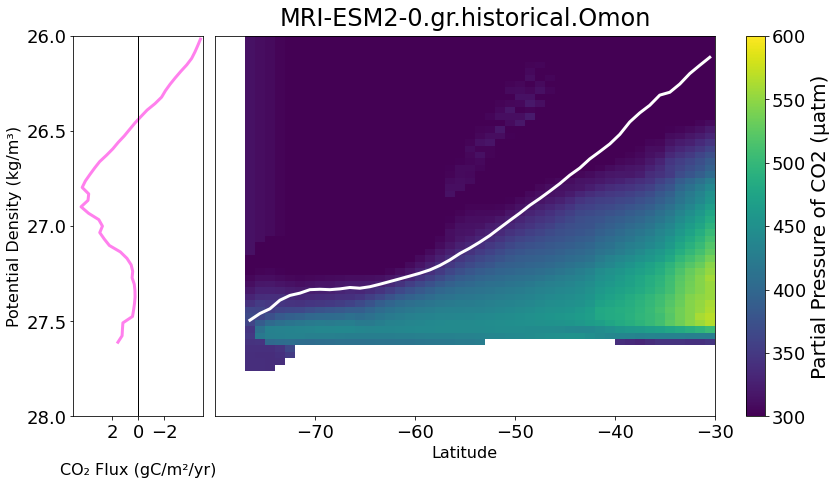

In [89]:
ds = dd_transform['MRI-ESM2-0.gr.historical.Omon']
name = 'MRI-ESM2-0.gr.historical.Omon'
fig = plt.figure(figsize=(15, 7)) 
select = {'y':slice(-80,-30)}
con_pos = np.linspace(0, 2e8, 10)
plt.rc('font', size = 18)
plt.rc('axes', titlesize= 24)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=20)

# axes
axco2 = plt.subplot2grid((6,12), (0,0), rowspan = 6, colspan = 2)
axPCO2 = plt.subplot2grid((6,12), (0, 2), rowspan = 6, colspan = 9)
# axSI = plt.subplot2grid((6,17), (0, 6), rowspan = 1, colspan = 9)
# axhfds = plt.subplot2grid((6,17), (1, 0), rowspan = 5, colspan = 2)
# axintpp = plt.subplot2grid((6,17), (1, 2), rowspan = 5, colspan = 2)
plt.subplots_adjust(hspace=0.2)
# axintpp.set_title('CESM2-FV2.gr.historical.Omon', fontsize = 16, pad = 30)

# co2
# plotting outgassing in red and ingassing  in blue
axco2.plot(ds.fgco2*1e3, ds.sigma0_outer2d, lw = 3, **model_kwargs[name])
# axco2.plot(ds.fgco2.where(ds.fgco2>=0)*1e3, ds.sigma0_outer2d, color =  'r')
# axco2.plot(ds.fgco2.where(ds.fgco2<=0)*1e3, ds.sigma0_outer2d, color =  'b')
axco2.axvline(x=0, color = 'k', lw = 1)
axco2.set_xticks([-2,0,2])
axco2.set_xlim([-5,5])
# axco2.set_xticklabels([-2,0,2], fontsize = 16)
axco2.set_yticks([26, 26.5, 27, 27.5, 28])
# axco2.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
axco2.set_ylim([26, 28])
axco2.set_xlabel('\nCO\u2082 Flux (gC/m\u00b2/yr)')
axco2.set_ylabel('Potential Density (kg/m\u00b3)')
axco2.invert_yaxis()
axco2.invert_xaxis()

# PCO2
im = axPCO2.pcolormesh(ds.y, ds.sigma0_outer3d, ds['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
cbar_label = 'Partial Pressure of CO2 (\u03BCatm)'
cbar = plt.colorbar(im,ax = axPCO2)
cbar.set_label(cbar_label, fontsize = 20)
# axPCO2.contour(psids.y, psids.sigma0,psids.transpose(),linestyles = 'solid', colors = 'k')
axPCO2.set_yticks([])
axPCO2.set_xticks([-70, -60, -50, -40, -30])
# axPCO2.set_xticklabels([-70, -60, -50, -40, -30], fontsize = 14)
axPCO2.set_ylim([26, 28])
axPCO2.invert_yaxis()
axPCO2.set_xlabel('Latitude')
axPCO2.set_title(name, pad = 10)

# mixed layer
da = dd[name]
present = da.data_vars
if 'mlotst' in present:
    axPCO2.plot(da.y, da.sigma0.sel(lev = da.mlotst, method = 'nearest').mean('x', keep_attrs = True), color = 'w', lw = 3)



this one might also make sense maybe

## UKESM1-0-LL
`color = '#8f5904'`

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


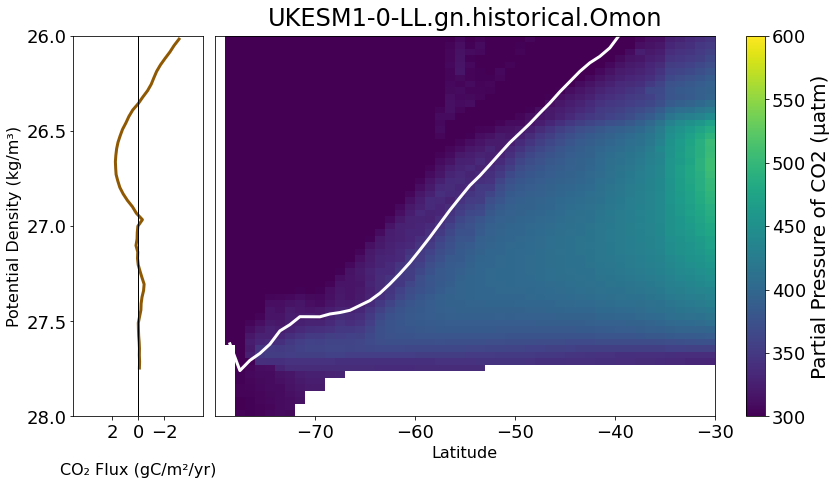

In [90]:
ds = dd_transform['UKESM1-0-LL.gn.historical.Omon']
name = 'UKESM1-0-LL.gn.historical.Omon'
fig = plt.figure(figsize=(15, 7)) 
select = {'y':slice(-80,-30)}
con_pos = np.linspace(0, 2e8, 10)
plt.rc('font', size = 18)
plt.rc('axes', titlesize= 24)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=20)

# axes
axco2 = plt.subplot2grid((6,12), (0,0), rowspan = 6, colspan = 2)
axPCO2 = plt.subplot2grid((6,12), (0, 2), rowspan = 6, colspan = 9)
# axSI = plt.subplot2grid((6,17), (0, 6), rowspan = 1, colspan = 9)
# axhfds = plt.subplot2grid((6,17), (1, 0), rowspan = 5, colspan = 2)
# axintpp = plt.subplot2grid((6,17), (1, 2), rowspan = 5, colspan = 2)
plt.subplots_adjust(hspace=0.2)
# axintpp.set_title('CESM2-FV2.gr.historical.Omon', fontsize = 16, pad = 30)

# co2
# plotting outgassing in red and ingassing  in blue
axco2.plot(ds.fgco2*1e3, ds.sigma0_outer2d, lw = 3, **model_kwargs[name])
# axco2.plot(ds.fgco2.where(ds.fgco2>=0)*1e3, ds.sigma0_outer2d, color =  'r')
# axco2.plot(ds.fgco2.where(ds.fgco2<=0)*1e3, ds.sigma0_outer2d, color =  'b')
axco2.axvline(x=0, color = 'k', lw = 1)
axco2.set_xticks([-2,0,2])
axco2.set_xlim([-5,5])
# axco2.set_xticklabels([-2,0,2], fontsize = 16)
axco2.set_yticks([26, 26.5, 27, 27.5, 28])
# axco2.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
axco2.set_ylim([26, 28])
axco2.set_xlabel('\nCO\u2082 Flux (gC/m\u00b2/yr)')
axco2.set_ylabel('Potential Density (kg/m\u00b3)')
axco2.invert_yaxis()
axco2.invert_xaxis()

# PCO2
im = axPCO2.pcolormesh(ds.y, ds.sigma0_outer3d, ds['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
cbar_label = 'Partial Pressure of CO2 (\u03BCatm)'
cbar = plt.colorbar(im,ax = axPCO2)
cbar.set_label(cbar_label, fontsize = 20)
# axPCO2.contour(psids.y, psids.sigma0,psids.transpose(),linestyles = 'solid', colors = 'k')
axPCO2.set_yticks([])
axPCO2.set_xticks([-70, -60, -50, -40, -30])
# axPCO2.set_xticklabels([-70, -60, -50, -40, -30], fontsize = 14)
axPCO2.set_ylim([26, 28])
axPCO2.invert_yaxis()
axPCO2.set_xlabel('Latitude')
axPCO2.set_title(name, pad = 10)

# mixed layer
da = dd[name]
present = da.data_vars
if 'mlotst' in present:
    axPCO2.plot(da.y, da.sigma0.sel(lev = da.mlotst, method = 'nearest').mean('x', keep_attrs = True), color = 'w', lw = 3)



## CanESM5
`color = '#ff8200'`

So I'm still left wondering what water masses are represented here. I also have a tiny voice in the back of my head saying that something might be weird because I'm using `sigma0` (as opposed to neutral density or density referenced to some other depth like 1000 meters or whatever).

At some point in this process of messing around, I did transform onto a larger range of densities (like 0 to 30) and that didn't provide any other relevant information

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


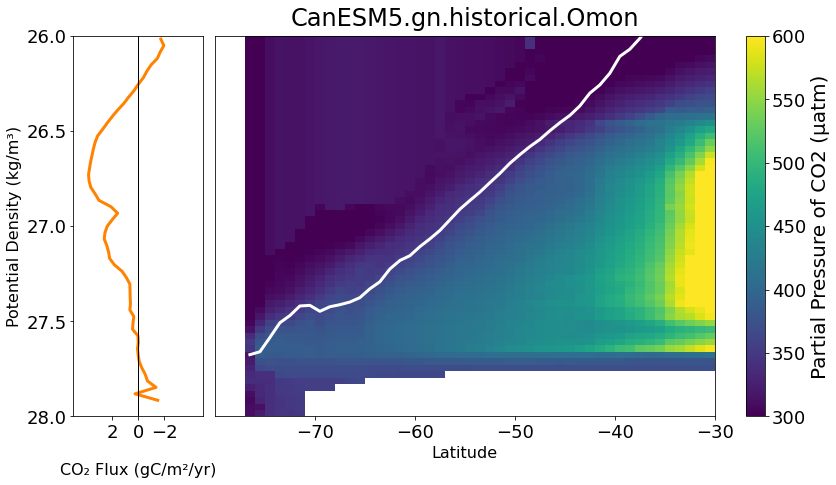

In [91]:
ds = dd_transform['CanESM5.gn.historical.Omon']
name = 'CanESM5.gn.historical.Omon'
fig = plt.figure(figsize=(15, 7)) 
select = {'y':slice(-80,-30)}
con_pos = np.linspace(0, 2e8, 10)
plt.rc('font', size = 18)
plt.rc('axes', titlesize= 24)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=20)

# axes
axco2 = plt.subplot2grid((6,12), (0,0), rowspan = 6, colspan = 2)
axPCO2 = plt.subplot2grid((6,12), (0, 2), rowspan = 6, colspan = 9)
# axSI = plt.subplot2grid((6,17), (0, 6), rowspan = 1, colspan = 9)
# axhfds = plt.subplot2grid((6,17), (1, 0), rowspan = 5, colspan = 2)
# axintpp = plt.subplot2grid((6,17), (1, 2), rowspan = 5, colspan = 2)
plt.subplots_adjust(hspace=0.2)
# axintpp.set_title('CESM2-FV2.gr.historical.Omon', fontsize = 16, pad = 30)

# co2
# plotting outgassing in red and ingassing  in blue
axco2.plot(ds.fgco2*1e3, ds.sigma0_outer2d, lw = 3, **model_kwargs[name])
# axco2.plot(ds.fgco2.where(ds.fgco2>=0)*1e3, ds.sigma0_outer2d, color =  'r')
# axco2.plot(ds.fgco2.where(ds.fgco2<=0)*1e3, ds.sigma0_outer2d, color =  'b')
axco2.axvline(x=0, color = 'k', lw = 1)
axco2.set_xticks([-2,0,2])
axco2.set_xlim([-5,5])
# axco2.set_xticklabels([-2,0,2], fontsize = 16)
axco2.set_yticks([26, 26.5, 27, 27.5, 28])
# axco2.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
axco2.set_ylim([26, 28])
axco2.set_xlabel('\nCO\u2082 Flux (gC/m\u00b2/yr)')
axco2.set_ylabel('Potential Density (kg/m\u00b3)')
axco2.invert_yaxis()
axco2.invert_xaxis()

# PCO2
im = axPCO2.pcolormesh(ds.y, ds.sigma0_outer3d, ds['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
cbar_label = 'Partial Pressure of CO2 (\u03BCatm)'
cbar = plt.colorbar(im,ax = axPCO2)
cbar.set_label(cbar_label, fontsize = 20)
# axPCO2.contour(psids.y, psids.sigma0,psids.transpose(),linestyles = 'solid', colors = 'k')
axPCO2.set_yticks([])
axPCO2.set_xticks([-70, -60, -50, -40, -30])
# axPCO2.set_xticklabels([-70, -60, -50, -40, -30], fontsize = 14)
axPCO2.set_ylim([26, 28])
axPCO2.invert_yaxis()
axPCO2.set_xlabel('Latitude')
axPCO2.set_title(name, pad = 10)

# mixed layer
da = dd[name]
present = da.data_vars
if 'mlotst' in present:
    axPCO2.plot(da.y, da.sigma0.sel(lev = da.mlotst, method = 'nearest').mean('x', keep_attrs = True), color = 'w', lw = 3)


## CESM2

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


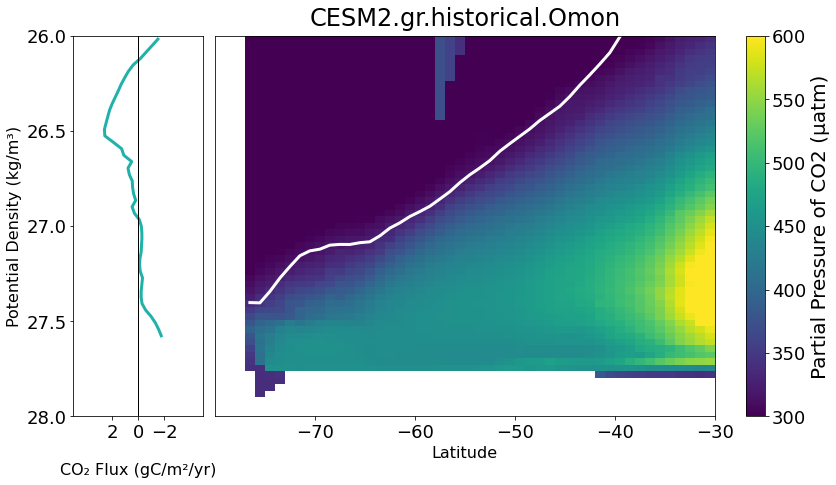

In [92]:
ds = dd_transform['CESM2.gr.historical.Omon']
name = 'CESM2.gr.historical.Omon'
fig = plt.figure(figsize=(15, 7)) 
select = {'y':slice(-80,-30)}
con_pos = np.linspace(0, 2e8, 10)
plt.rc('font', size = 18)
plt.rc('axes', titlesize= 24)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=20)

# axes
axco2 = plt.subplot2grid((6,12), (0,0), rowspan = 6, colspan = 2)
axPCO2 = plt.subplot2grid((6,12), (0, 2), rowspan = 6, colspan = 9)
# axSI = plt.subplot2grid((6,17), (0, 6), rowspan = 1, colspan = 9)
# axhfds = plt.subplot2grid((6,17), (1, 0), rowspan = 5, colspan = 2)
# axintpp = plt.subplot2grid((6,17), (1, 2), rowspan = 5, colspan = 2)
plt.subplots_adjust(hspace=0.2)
axintpp.set_title('CESM2-FV2.gr.historical.Omon', fontsize = 16, pad = 30)

# co2
# plotting outgassing in red and ingassing  in blue
axco2.plot(ds.fgco2*1e3, ds.sigma0_outer2d, lw = 3, **model_kwargs[name])
# axco2.plot(ds.fgco2.where(ds.fgco2>=0)*1e3, ds.sigma0_outer2d, color =  'r')
# axco2.plot(ds.fgco2.where(ds.fgco2<=0)*1e3, ds.sigma0_outer2d, color =  'b')
axco2.axvline(x=0, color = 'k', lw = 1)
axco2.set_xticks([-2,0,2])
axco2.set_xlim([-5,5])
# axco2.set_xticklabels([-2,0,2], fontsize = 16)
axco2.set_yticks([26, 26.5, 27, 27.5, 28])
# axco2.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
axco2.set_ylim([26, 28])
axco2.set_xlabel('\nCO\u2082 Flux (gC/m\u00b2/yr)')
axco2.set_ylabel('Potential Density (kg/m\u00b3)')
axco2.invert_yaxis()
axco2.invert_xaxis()

# PCO2
im = axPCO2.pcolormesh(ds.y, ds.sigma0_outer3d, ds['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
cbar_label = 'Partial Pressure of CO2 (\u03BCatm)'
cbar = plt.colorbar(im,ax = axPCO2)
cbar.set_label(cbar_label, fontsize = 20)
# axPCO2.contour(psids.y, psids.sigma0,psids.transpose(),linestyles = 'solid', colors = 'k')
axPCO2.set_yticks([])
axPCO2.set_xticks([-70, -60, -50, -40, -30])
# axPCO2.set_xticklabels([-70, -60, -50, -40, -30], fontsize = 14)
axPCO2.set_ylim([26, 28])
axPCO2.invert_yaxis()
axPCO2.set_xlabel('Latitude')
axPCO2.set_title(name, pad = 10)

# mixed layer
da = dd[name]
present = da.data_vars
if 'mlotst' in present:
    axPCO2.plot(da.y, da.sigma0.sel(lev = da.mlotst, method = 'nearest').mean('x', keep_attrs = True), color = 'w', lw = 3)

# # intpp
# # all values in blue since PP consumes carbon
# present = ds.data_vars
# if 'intpp' in present:
#     axintpp.plot(ds.intpp, ds.sigma0_outer2d, color = 'b')
#     axintpp.set_yticks([])
#     axintpp.set_yticklabels([], fontsize = 16)
#     axintpp.set_ylim([26, 28])
#     axintpp.invert_yaxis()
#     axintpp.set_xlabel('PP')

# # heat flux
# # blue for negative, red for positive
# if 'hfds' in present:
#     axhfds.plot(ds.hfds.where(ds.hfds>=0), ds.sigma0_outer2d, color = 'r')
#     axhfds.plot(ds.hfds.where(ds.hfds<=0), ds.sigma0_outer2d, color = 'b')
#     axhfds.set_yticks([26, 26.5, 27, 27.5, 28])
#     # axhfds.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
#     axhfds.set_ylim([26, 28])
#     axhfds.invert_yaxis()
#     axhfds.set_ylabel('Potential Density')
#     axhfds.set_xlabel('Heat Flux')

# # switch y ticks to the right side for space
# axS.yaxis.tick_right()



## CESM2-WACCM

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


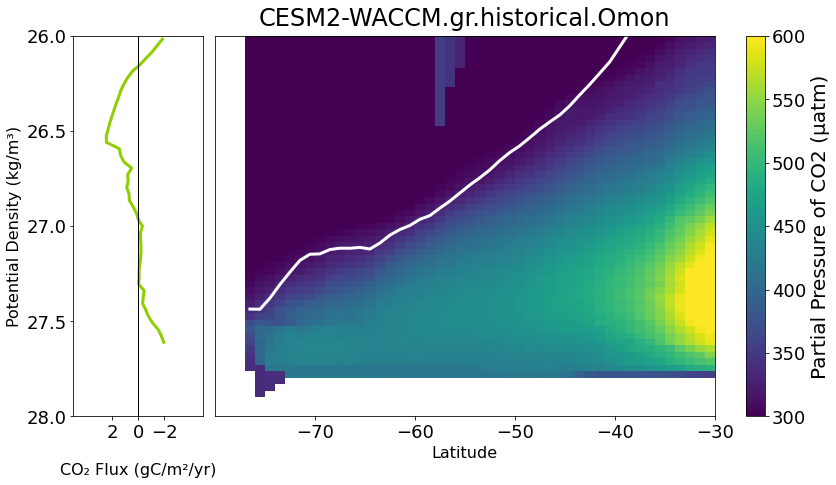

In [93]:
ds = dd_transform['CESM2-WACCM.gr.historical.Omon']
name = 'CESM2-WACCM.gr.historical.Omon'
fig = plt.figure(figsize=(15, 7)) 
select = {'y':slice(-80,-30)}
con_pos = np.linspace(0, 2e8, 10)
plt.rc('font', size = 18)
plt.rc('axes', titlesize= 24)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=20)

# axes
axco2 = plt.subplot2grid((6,12), (0,0), rowspan = 6, colspan = 2)
axPCO2 = plt.subplot2grid((6,12), (0, 2), rowspan = 6, colspan = 9)
# axSI = plt.subplot2grid((6,17), (0, 6), rowspan = 1, colspan = 9)
# axhfds = plt.subplot2grid((6,17), (1, 0), rowspan = 5, colspan = 2)
# axintpp = plt.subplot2grid((6,17), (1, 2), rowspan = 5, colspan = 2)
plt.subplots_adjust(hspace=0.2)
axintpp.set_title('CESM2-FV2.gr.historical.Omon', fontsize = 16, pad = 30)

# co2
# plotting outgassing in red and ingassing  in blue
axco2.plot(ds.fgco2*1e3, ds.sigma0_outer2d, lw = 3, **model_kwargs[name])
# axco2.plot(ds.fgco2.where(ds.fgco2>=0)*1e3, ds.sigma0_outer2d, color =  'r')
# axco2.plot(ds.fgco2.where(ds.fgco2<=0)*1e3, ds.sigma0_outer2d, color =  'b')
axco2.axvline(x=0, color = 'k', lw = 1)
axco2.set_xticks([-2,0,2])
axco2.set_xlim([-5,5])
# axco2.set_xticklabels([-2,0,2], fontsize = 16)
axco2.set_yticks([26, 26.5, 27, 27.5, 28])
# axco2.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
axco2.set_ylim([26, 28])
axco2.set_xlabel('\nCO\u2082 Flux (gC/m\u00b2/yr)')
axco2.set_ylabel('Potential Density (kg/m\u00b3)')
axco2.invert_yaxis()
axco2.invert_xaxis()

# PCO2
im = axPCO2.pcolormesh(ds.y, ds.sigma0_outer3d, ds['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
cbar_label = 'Partial Pressure of CO2 (\u03BCatm)'
cbar = plt.colorbar(im,ax = axPCO2)
cbar.set_label(cbar_label, fontsize = 20)
# axPCO2.contour(psids.y, psids.sigma0,psids.transpose(),linestyles = 'solid', colors = 'k')
axPCO2.set_yticks([])
axPCO2.set_xticks([-70, -60, -50, -40, -30])
# axPCO2.set_xticklabels([-70, -60, -50, -40, -30], fontsize = 14)
axPCO2.set_ylim([26, 28])
axPCO2.invert_yaxis()
axPCO2.set_xlabel('Latitude')
axPCO2.set_title(name, pad = 10)

# mixed layer
da = dd[name]
present = da.data_vars
if 'mlotst' in present:
    axPCO2.plot(da.y, da.sigma0.sel(lev = da.mlotst, method = 'nearest').mean('x', keep_attrs = True), color = 'w', lw = 3)

# # intpp
# # all values in blue since PP consumes carbon
# present = ds.data_vars
# if 'intpp' in present:
#     axintpp.plot(ds.intpp, ds.sigma0_outer2d, color = 'b')
#     axintpp.set_yticks([])
#     axintpp.set_yticklabels([], fontsize = 16)
#     axintpp.set_ylim([26, 28])
#     axintpp.invert_yaxis()
#     axintpp.set_xlabel('PP')

# # heat flux
# # blue for negative, red for positive
# if 'hfds' in present:
#     axhfds.plot(ds.hfds.where(ds.hfds>=0), ds.sigma0_outer2d, color = 'r')
#     axhfds.plot(ds.hfds.where(ds.hfds<=0), ds.sigma0_outer2d, color = 'b')
#     axhfds.set_yticks([26, 26.5, 27, 27.5, 28])
#     # axhfds.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
#     axhfds.set_ylim([26, 28])
#     axhfds.invert_yaxis()
#     axhfds.set_ylabel('Potential Density')
#     axhfds.set_xlabel('Heat Flux')

# # switch y ticks to the right side for space
# axS.yaxis.tick_right()



## CESM2-WACCM-FV2

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


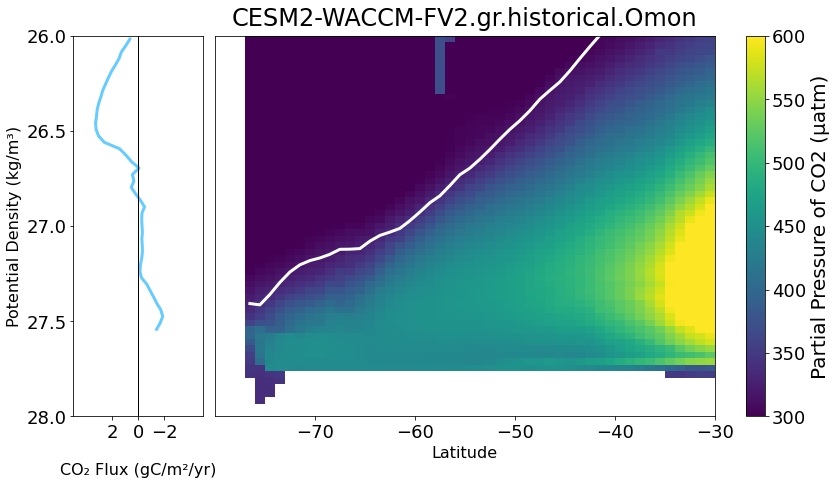

In [94]:
ds = dd_transform['CESM2-WACCM-FV2.gr.historical.Omon']
name = 'CESM2-WACCM-FV2.gr.historical.Omon'
fig = plt.figure(figsize=(15, 7)) 
select = {'y':slice(-80,-30)}
con_pos = np.linspace(0, 2e8, 10)
plt.rc('font', size = 18)
plt.rc('axes', titlesize= 24)    
plt.rc('axes', labelsize= 16)
plt.rc('figure', titlesize=20)

# axes
axco2 = plt.subplot2grid((6,12), (0,0), rowspan = 6, colspan = 2)
axPCO2 = plt.subplot2grid((6,12), (0, 2), rowspan = 6, colspan = 9)
# axSI = plt.subplot2grid((6,17), (0, 6), rowspan = 1, colspan = 9)
# axhfds = plt.subplot2grid((6,17), (1, 0), rowspan = 5, colspan = 2)
# axintpp = plt.subplot2grid((6,17), (1, 2), rowspan = 5, colspan = 2)
plt.subplots_adjust(hspace=0.2)
axintpp.set_title('CESM2-FV2.gr.historical.Omon', fontsize = 16, pad = 30)

# co2
# plotting outgassing in red and ingassing  in blue
axco2.plot(ds.fgco2*1e3, ds.sigma0_outer2d, lw = 3, **model_kwargs[name])
# axco2.plot(ds.fgco2.where(ds.fgco2>=0)*1e3, ds.sigma0_outer2d, color =  'r')
# axco2.plot(ds.fgco2.where(ds.fgco2<=0)*1e3, ds.sigma0_outer2d, color =  'b')
axco2.axvline(x=0, color = 'k', lw = 1)
axco2.set_xticks([-2,0,2])
axco2.set_xlim([-5,5])
# axco2.set_xticklabels([-2,0,2], fontsize = 16)
axco2.set_yticks([26, 26.5, 27, 27.5, 28])
# axco2.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
axco2.set_ylim([26, 28])
axco2.set_xlabel('\nCO\u2082 Flux (gC/m\u00b2/yr)')
axco2.set_ylabel('Potential Density (kg/m\u00b3)')
axco2.invert_yaxis()
axco2.invert_xaxis()

# PCO2
im = axPCO2.pcolormesh(ds.y, ds.sigma0_outer3d, ds['PCO2'].transpose('sigma0_outer3d', 'y'), vmin = 300, vmax = 600)
cbar_label = 'Partial Pressure of CO2 (\u03BCatm)'
cbar = plt.colorbar(im,ax = axPCO2)
cbar.set_label(cbar_label, fontsize = 20)
# axPCO2.contour(psids.y, psids.sigma0,psids.transpose(),linestyles = 'solid', colors = 'k')
axPCO2.set_yticks([])
axPCO2.set_xticks([-70, -60, -50, -40, -30])
# axPCO2.set_xticklabels([-70, -60, -50, -40, -30], fontsize = 14)
axPCO2.set_ylim([26, 28])
axPCO2.invert_yaxis()
axPCO2.set_xlabel('Latitude')
axPCO2.set_title(name, pad = 10)

# mixed layer
da = dd[name]
present = da.data_vars
if 'mlotst' in present:
    axPCO2.plot(da.y, da.sigma0.sel(lev = da.mlotst, method = 'nearest').mean('x', keep_attrs = True), color = 'w', lw = 3)

# # intpp
# # all values in blue since PP consumes carbon
# present = ds.data_vars
# if 'intpp' in present:
#     axintpp.plot(ds.intpp, ds.sigma0_outer2d, color = 'b')
#     axintpp.set_yticks([])
#     axintpp.set_yticklabels([], fontsize = 16)
#     axintpp.set_ylim([26, 28])
#     axintpp.invert_yaxis()
#     axintpp.set_xlabel('PP')

# # heat flux
# # blue for negative, red for positive
# if 'hfds' in present:
#     axhfds.plot(ds.hfds.where(ds.hfds>=0), ds.sigma0_outer2d, color = 'r')
#     axhfds.plot(ds.hfds.where(ds.hfds<=0), ds.sigma0_outer2d, color = 'b')
#     axhfds.set_yticks([26, 26.5, 27, 27.5, 28])
#     # axhfds.set_yticklabels([26, 26.5, 27, 27.5, 28], fontsize = 16)
#     axhfds.set_ylim([26, 28])
#     axhfds.invert_yaxis()
#     axhfds.set_ylabel('Potential Density')
#     axhfds.set_xlabel('Heat Flux')

# # switch y ticks to the right side for space
# axS.yaxis.tick_right()

